In [1]:
import csv
import numpy as np

In [2]:
global_lengths = []
def get_characters_and_floor_bin(match_str):
    # This is the separator between the character codes and the match datetime: 0x95 0xB2
    # However sometimes it can appear multiple times because some other data is coincidentally set to the same values
    # Those cases are very rare however approx 3 in 80000
    index = match_str.index(b'\x95\xb2')
    global_lengths.append(index)
    raw_bytes = match_str[index-3:index]
    char_codes = [int(x) for x in raw_bytes]
    if max(char_codes[1:]) > 16:
        raise Exception('TOO MANY MATCHES',match_str.count(b'\x95\xb2'),match_str)
    return char_codes

def get_winner_bin(match_str):
    raw_bytes = int(match_str[-1])
    return raw_bytes

def get_date_bin(match_str):
    return match_str[:14].decode()

def get_match_data_bin(match_str):
    data = get_characters_and_floor_bin(match_str)
    winner = get_winner_bin(match_str)
    data.append(get_winner_bin(match_str))
    data.append(data[winner])
    data.insert(0,get_date_bin(match_str))
    
    return data

In [3]:
with open('outputs/replaysRAW.txt', "rb") as f:
    data = f.read()
    # When writing the files from the modified totsugeki.exe we use a sequence of 8 0xF2 as a delimiter between calls
    bin_matches = data.split(b'\xf2\xf2\xf2\xf2\xf2\xf2\xf2\xf2')


match_list = []
match_list_raw = []
match_list_bin = []
# page here denotes a set of games when scrolling through the replays list
for page in bin_matches:
    match_str_list = page.split(b'\xb32021\x2d')
    # The first and last match strings are not formatted the same as the rest
    # I think they might contain metadata about the request
    # TODO: Isolate and investigate what exactly that is
    for match_str in match_str_list[1:-1]:
        try:
            match_list_bin.append(match_str)
            match_list_raw.append(np.array([x for x in match_str]))
            match_list.append(get_match_data_bin(match_str))
        except Exception as e:
            pass
#             print(e, [x for x in match_str])

In [5]:
with open('GGST_Replays.csv', 'w', newline='') as f:
    fields  = ['date','floor','p1CharCode','p2CharCode', 'winner', 'winnerCharCode']
    writer = csv.writer(f)
    writer.writerow(fields)
    writer.writerows(match_list)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
LOCAL_TIMEZONE = datetime.datetime.now().astimezone().tzinfo

In [7]:
df =pd.read_csv('GGST_Replays.csv')

In [8]:
df.head()

,date,floor,p1CharCode,p2CharCode,winner,winnerCharCode
0,09-26 19:20:07,6,3,6,1,3
1,09-26 19:17:45,6,3,6,2,6
2,09-26 19:14:56,6,11,6,1,11
3,09-26 19:09:17,99,4,13,2,13
4,09-26 03:55:48,99,4,13,1,4


In [9]:
df.shape

(416504, 6)

In [10]:
print('data was collected between', df['date'].min(), 'and', df['date'].max()) 

data was collected between 09-25 00:39:36 and 09-26 19:20:07


In [11]:
def convert_to_datetime(api_date):
    return np.datetime64('2021-'+api_date)

# TODO:  fix this
def convert_to_hours_and_mins(api_date):
    return np.datetime64(api_date[6:].replace(':','-'))

# convert_to_hours_and_mins(df['date'][0])
df['date'] = df['date'].apply(convert_to_datetime)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


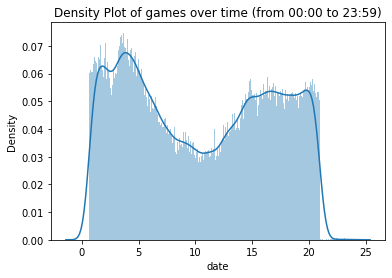

In [12]:
# NOTE: these times are from the timezone where the data was collected
# in my case this is UTC+2
time_of_day = pd.DatetimeIndex(df['date']).hour + pd.DatetimeIndex(df['date']).minute/60
plt.title('Density Plot of games over time (from 00:00 to 23:59)')
plt.show(sns.distplot(time_of_day , bins=24*30))

In [35]:
from matplotlib.pyplot import figure
class Replay_Analyser:
    readable_character_names = ['sol', 'ky', 'may', 'axl', 'chipp', 'potemkin', 'faust', 'millia', 'zato', 'ramlethal', 'leo', 'nagoriyuki', 'giovanna', 'anji', 'i-no', 'goldlewis', 'jack-o']
    chars, counts = np.unique(df[['p1CharCode','p2CharCode']].to_numpy(), return_counts=True)
    num_chars = len(readable_character_names)
    num_floors = 11
    def __init__(self, filepath='GGST_Replays.csv', floors_to_examine = [99]):
        self.df = pd.read_csv(filepath)
        self.floors_text = 'floors ' if len(floors_to_examine) > 1 else 'floor '
        self.floors_text = self.floors_text + str(tuple(floors_to_examine))
        self.calculate_win_loss_stats(floors_to_examine)
        
        
    def calculate_win_loss_stats(self, floors_to_examine):
        wins = np.zeros(self.num_chars)
        losses = np.zeros(self.num_chars)
        duplicates = np.zeros(self.num_chars)
        matchup_wins = np.zeros((self.num_chars,self.num_chars))
        matchup_losses = np.zeros((self.num_chars,self.num_chars))
        
        num_games_at_floor = np.zeros(self.num_floors)
        print("FlOORS", floors_to_examine)
        for index, row in df.iterrows():
            # print(row['floor'], row['floor'] in floors_to_examine)
            if row['floor'] in floors_to_examine:
                winner = row['p1CharCode'] if row['winner'] == 1 else row['p2CharCode']
                loser  = row['p1CharCode'] if row['winner'] == 2 else row['p2CharCode']
                # print(winner, loser, row['winner'])
                wins[winner] += 1
                losses[loser] += 1
                matchup_wins[winner][loser] += 1
                matchup_losses[loser][winner] += 1

                # if winner == loser:
                #     duplicates[winner] += 1
                #     duplicates[loser] += 1

            if row['floor'] == 99:
                num_games_at_floor[10] += 1
            else:
                num_games_at_floor[row['floor']] += 1
        
        total_games = (wins+losses)
        total_games -= duplicates
        print("total wins", np.sum(wins))
        print("total losses", np.sum(losses))
        print("total games", np.sum(total_games))
        winrate = wins/total_games
        print("mean winrate", np.mean(winrate))

        matchup_totals = matchup_wins+matchup_losses
        matchup_table = matchup_wins/matchup_totals
        character_winrate_data = list(zip(self.readable_character_names, np.around(winrate,4), total_games))
        figure(figsize=(10, 10), dpi=80)
        plt.title('Character Winrates at ' + self.floors_text)
        y,x = zip(*sorted(zip(np.around(winrate*100,4), self.readable_character_names)))
        for index, value in enumerate(y):
            plt.text(value-5, index, str(value))
        plt.barh(x, y)
        print('Character winrates/ games played', sorted(character_winrate_data,key=lambda x : x[1]))
        self.total_games = total_games
        self.winrate = winrate
        self.matchup_totals = matchup_totals
        self.matchup_table = matchup_table
        self.floors_to_examine = floors_to_examine
        self.num_games_at_floor = num_games_at_floor
        self.initialized = True
        return total_games, winrate, matchup_totals, matchup_table, floors_to_examine
    
    def calculate_character_usage_stats(self):
        if self.initialized:
            plt.gcf()
            plt.title('Character Usage Pie Chart at ' + self.floors_text)
            plt.savefig('Character Usage Pie Chart at ' + self.floors_text)
            plt.show(plt.pie(self.total_games, labels=self.readable_character_names, autopct=lambda x : str(int(np.round(x)))+'%'))
        else:
            print('Analyser not properly initialized')
            
    def calculate_games_played_at_each_floor(self):
        if self.initialized:
            x , y = list(range(1,12)), self.num_games_at_floor
            plt.gcf()
            plt.title('Number of games played at each floor')
            plt.savefig('Number of games played at each floor')
            plt.show(plt.bar(x, y))
        else:
            print('Analyser not properly initialized')
            
    def calculate_matchup_table(self):
        figure(figsize=(10, 10), dpi=80)
        title = 'Matchup Winrate Heatmap (Read Horizontally) at \n'  
        title += 'How many games out of 10 would the average player win? \n'
        title += '[Data from ' + self.floors_text+ ']'
        plt.title(title)
        ratios = (self.matchup_table)*10
        plt.gcf()
        plt.savefig('Matchup Winrate Heatmap at '+ self.floors_text)
        plt.show(sns.heatmap(ratios, linewidth=0.5,xticklabels = self.readable_character_names, yticklabels =self.readable_character_names, cmap="PiYG", annot=ratios))
        
    def calculate_matchups_played_table(self):
        figure(figsize=(10, 10), dpi=80)
        annotations = self.matchup_totals
        title = 'Which Matchups Are Most Played at ' + self.floors_text + '?'
        plt.gcf()
        plt.title(title)
        plt.savefig(title[:-1])        
        plt.show(sns.heatmap(self.matchup_totals, linewidth=0.5,xticklabels = self.readable_character_names, yticklabels = self.readable_character_names, cmap="Blues",annot=True, fmt='g'))


FlOORS [99]
total wins 113136.0
total losses 113136.0
total games 226272.0
mean winrate 0.49911306581766035
Character winrates/ games played [('faust', 0.4318, 7462.0), ('millia', 0.463, 14744.0), ('jack-o', 0.4639, 11066.0), ('anji', 0.4766, 11450.0), ('sol', 0.4808, 18500.0), ('may', 0.493, 15038.0), ('chipp', 0.5049, 10299.0), ('ramlethal', 0.5056, 14971.0), ('ky', 0.5058, 20481.0), ('i-no', 0.5063, 12063.0), ('giovanna', 0.5099, 14170.0), ('potemkin', 0.5109, 14573.0), ('leo', 0.5167, 12281.0), ('axl', 0.5185, 10223.0), ('zato', 0.5214, 9786.0), ('nagoriyuki', 0.5269, 21659.0), ('goldlewis', 0.5489, 7506.0)]


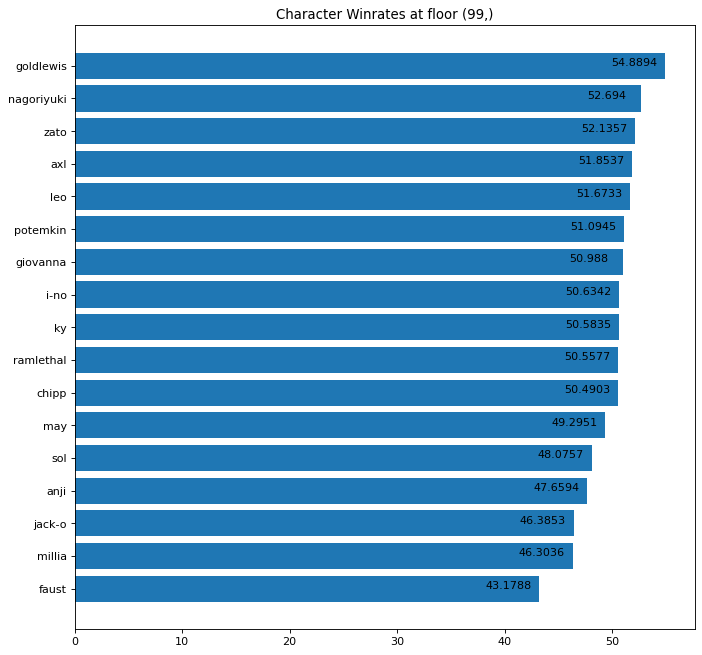

In [37]:
analyser = Replay_Analyser(floors_to_examine=[99])

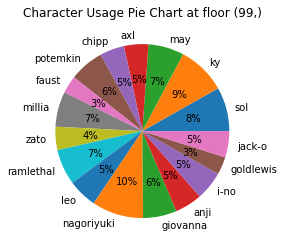

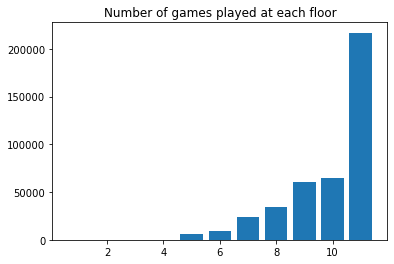

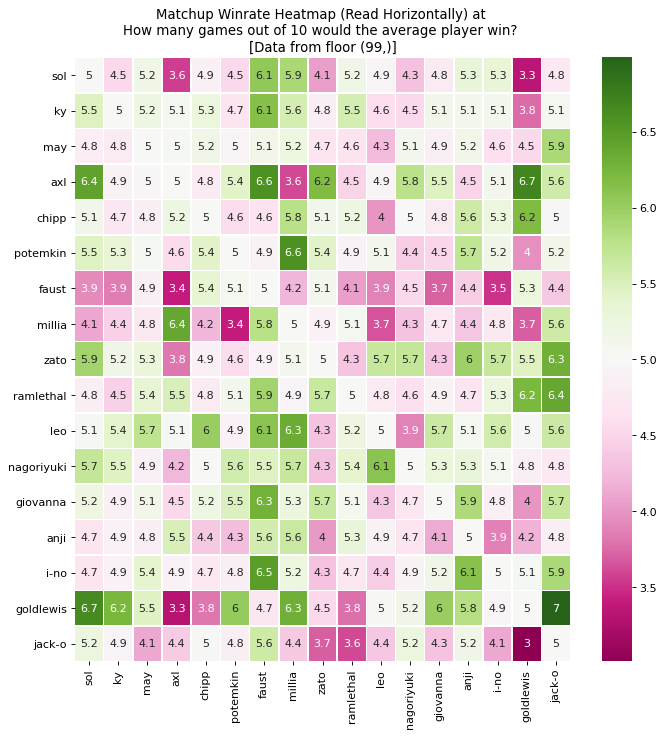

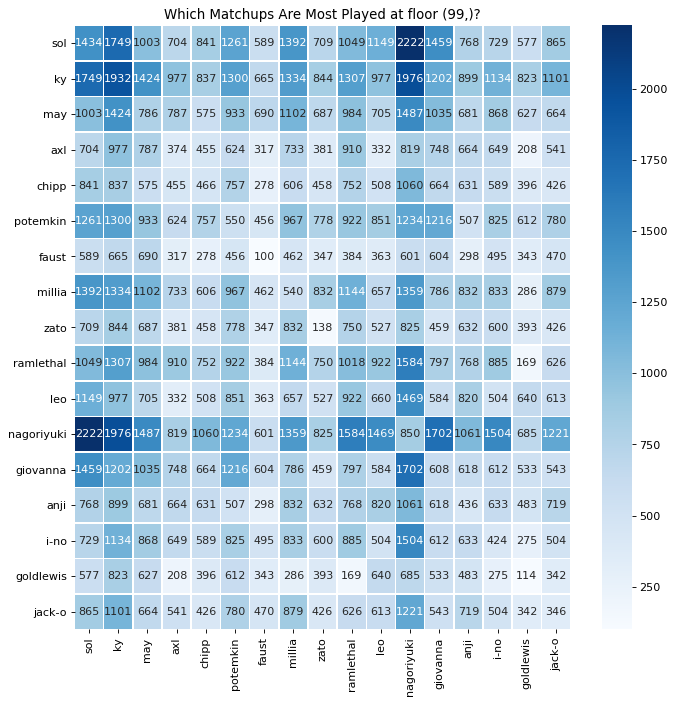

In [38]:
analyser.calculate_character_usage_stats()
analyser.calculate_games_played_at_each_floor()
analyser.calculate_matchup_table()
analyser.calculate_matchups_played_table()

In [16]:
least_played_matchup = np.unravel_index(np.argmin(matchup_totals, axis=None), matchup_totals.shape)
least_played_matchup_human_readable = [readable_character_names[x] for x in least_played_matchup]
least_played_matchup_value = np.min(matchup_totals)
print('least played matchup is:', least_played_matchup_human_readable, 'with ',least_played_matchup_value, 'games played in total')

NameError: name 'matchup_totals' is not defined

In [ ]:
most_played_matchup = np.unravel_index(np.argmax(matchup_totals, axis=None), matchup_totals.shape)
most_played_matchup_human_readable = [readable_character_names[x] for x in most_played_matchup]
most_played_matchup_value = np.max(matchup_totals)
print('most played matchup is:', most_played_matchup_human_readable, 'with ',most_played_matchup_value, 'games played in total')

In [ ]:
play_percentage = total_games/sum(total_games) 
# to find P(A and B) simply take P(A) * P(B)

num_chars = len(play_percentage)
predicted_matchup_rates = np.zeros((num_chars,num_chars))
for i in range(num_chars):
    for k in range(num_chars):
        predicted_matchup_rates[i][k] = play_percentage[i] * play_percentage[k]

predicted_matchup_values = np.around(predicted_matchup_rates*sum(total_games)) 

In [ ]:
figure(figsize=(10, 10), dpi=80)
plt.title('Which Matchups Are PREDICTED to be most played?')
plt.show(sns.heatmap(predicted_matchup_values, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="Blues",annot=True, fmt='g'))

In [ ]:
figure(figsize=(10, 10), dpi=80)
plt.title('Which matches are avoided?')
matchup_prediction_error = (matchup_totals - predicted_matchup_values)/matchup_totals
print(np.max(matchup_prediction_error), np.min(matchup_prediction_error))
plt.show(sns.heatmap(matchup_prediction_error, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="PiYG",annot=True, fmt='.0%',vmin=-0.8,vmax=0.8))